# Classify the bird species that appear on an image based on the use of a Convolutional Neural Network model

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping
###
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
###
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dirs = os.listdir('/content/drive/My Drive/TPCN')
print(dirs)

Mounted at /content/drive
['dataset.zip', 'datasetttt']


In [ ]:
!unzip -q '/content/drive/My Drive/TPCN/dataset.zip'

In [ ]:
trainDirectory = os.listdir('dataset/train')
species = trainDirectory
trainLabels = species
print(trainLabels)

['RED HONEY CREEPER', 'ALEXANDRINE PARAKEET', 'DOWNY WOODPECKER', 'BALI STARLING', 'ANNAS HUMMINGBIRD', 'GUINEA TURACO', 'COCKATOO', 'FRIGATE', 'WILSONS BIRD OF PARADISE', 'BROWN THRASHER', 'INDIAN PITTA', 'MARABOU STORK', 'SHORT BILLED DOWITCHER', 'SWINHOES PHEASANT', 'MALEO', 'TURQUOISE MOTMOT', 'JABIRU', 'HORNED GUAN', 'KIWI', 'RED BEARDED BEE EATER', 'SAMATRAN THRUSH', 'TAKAHE', 'STRIPPED SWALLOW', 'RED WISKERED BULBUL', 'EASTERN MEADOWLARK', 'WILD TURKEY', 'DARK EYED JUNCO', 'VIOLET GREEN SWALLOW', 'COMMON GRACKLE', 'NORTHERN PARULA', 'NORTHERN RED BISHOP', 'CASSOWARY', 'SCARLET IBIS', 'CRESTED CARACARA', 'HOUSE SPARROW', 'WHIMBREL', 'BANANAQUIT', 'VENEZUELIAN TROUPIAL', 'TASMANIAN HEN', 'KAKAPO', 'COCK OF THE  ROCK', 'WHITE TAILED TROPIC', 'STORK BILLED KINGFISHER', 'TIT MOUSE', 'BLUE GROUSE', 'KING VULTURE', 'VERMILION FLYCATHER', 'EASTERN ROSELLA', 'HOODED MERGANSER', 'OKINAWA RAIL', 'YELLOW BELLIED FLOWERPECKER', 'BLACK-CAPPED CHICKADEE', 'GYRFALCON', 'PEREGRINE FALCON', 'CUBA

In [ ]:
nSpecies = len(np.unique(species))
print('Number of species for train:', nSpecies)

Number of species for train: 250


In [ ]:
testSpecies = os.listdir('dataset/test')
testLabels = testSpecies
print('Number of test species:',len(np.unique(testSpecies)))

valid = os.listdir('dataset/valid')
validationLabels = valid
print('Number of validation species:',len(np.unique(valid)))

Number of test species: 250
Number of validation species: 250


#### Print one of the training images

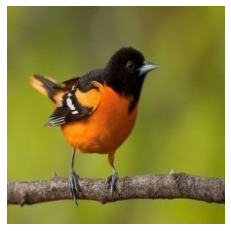

Image size + color channels: (224, 224, 3)


In [ ]:
img = load_img('dataset/train/BALTIMORE ORIOLE/027.jpg')
plt.imshow(img)
plt.axis("off")
plt.show()

imgData = img_to_array(img)
shape = imgData.shape
print('Image size + color channels:', shape)

#### Number of images of each species

In [ ]:
# train dataset
n = []
for dirr in species: 
    list = os.listdir('dataset/train')
    n.append(len(list))

print('Train - Minimum number of images found in a class:', min(n))
print('Train - Maximum number of images found in a class:', max(n), '\n')

# test dataset
ntest = []
for dirr in species: 
    list = os.listdir('dataset/test')
    ntest.append(len(list))

print('Test - Minimum number of images found in a class:', min(ntest))
print('Test - Maximum number of images found in a class:', max(ntest), '\n')

# validation dataset
nval = []
for dirr in species:
    d = os.path.join('dataset', 'valid')    
    list = os.listdir('dataset/valid')
    nval.append(len(list))

print('Valid - Minimum number of images found in a class:', min(nval))
print('Valid - Maximum number of images found in a class:', max(nval))

Train - Minimum number of images found in a class: 250
Train - Maximum number of images found in a class: 250 

Test - Minimum number of images found in a class: 250
Test - Maximum number of images found in a class: 250 

Valid - Minimum number of images found in a class: 250
Valid - Maximum number of images found in a class: 250


#### Visual analysis of the distribuition of the images on all the datasets

{'boxes': [<matplotlib.lines.Line2D at 0x7f759d173f90>],
 'caps': [<matplotlib.lines.Line2D at 0x7f759d181fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f759d173550>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f759d108ad0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f759d181550>,
  <matplotlib.lines.Line2D at 0x7f759d181a90>]}

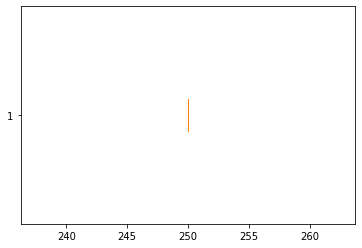

In [ ]:
# train dataset
################ax5.set_title('Train Images')
fig5, ax5 = plt.subplots()
square = dict(markerfacecolor='orange')
ax5.boxplot(n, vert=False, flierprops=square)

## Load and prepare images

#### Normalization

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
trainData = datagen.flow_from_directory('dataset/train', target_size = (100, 100), class_mode='categorical')
steps = len(trainData)
testData = datagen.flow_from_directory('dataset/test', target_size =  (100, 100), class_mode='categorical')
testSteps = len(testData)
validData = datagen.flow_from_directory('dataset/valid', target_size =  (100, 100), class_mode='categorical')
validSteps = len(validData)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


# CNN + GA

In [ ]:
# Build a generic CNN
def createModel(cl, filters, aFunc, optFunc, lossFunc, lr, drop, pad):
    model = Sequential()
    
    # first convolution layer
    model.add(Conv2D(filters, kernel_size=(3,3), padding=pad, input_shape=(100, 100,3), activation=aFunc))
    model.add(BatchNormalization())

    # middle convolutional layers  
    for i in range(int(cl)):
        model.add(Conv2D(filters, kernel_size=(3,3), padding=pad, input_shape=(100, 100,3), activation=aFunc))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(drop))
        
    # flattening
    model.add(Flatten())
    model.add(Dropout(drop))
    # full connection
    model.add(Dense(filters,activation='relu'))
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(drop))

    # output layer
    model.add(Dense(nSpecies,activation="softmax"))
    
    if(optFunc == 'SGD'): optFunc = SGD(learning_rate=lr)
    elif(optFunc == 'Adam'): optFunc = Adam(learning_rate=lr)
    elif(optFunc == 'Adagrad'): optFunc = Adagrad(learning_rate=lr)
    elif(optFunc == 'RMSprop'): optFunc = RMSprop(learning_rate=lr)

    #compile model
    model.compile(optFunc, loss=lossFunc, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    #model.summary()

    return model

In [ ]:
# Create the initial population
def createNewPopulation():
    
    population=[]
    
    for i in range(8):
        c=[]
        # number of middle convolutional layers
        c.append(np.random.randint(low=1, high=5))
        # number of filters
        c.append(np.random.choice([32, 64, 128, 256]))
        # activation function
        c.append(np.random.randint(low=0, high=3))
        # optimizer
        c.append(np.random.randint(low=0, high=4))
        # loss function
        c.append(np.random.randint(low=0, high=2))
        # learning rate 
        c.append(np.random.choice([0.001, 0.01, 0.1]))
        # dropout
        c.append(np.random.choice([0.15, 0.25, 0.3, 0.5]))
        # padding
        c.append(np.random.randint(low=0, high=2))
        population.append(c)
        
    return np.array(population)

# Update the models parameters
def updateModelParameters(params):
    if((params[2]) == 0): aFunc = 'relu'
    if((params[2]) == 1): aFunc = 'selu'
    if((params[2]) == 2): aFunc = 'softmax'

    if((params[3]) == 0): optFunc = 'SGD'
    if((params[3]) == 1): optFunc = 'Adam'
    if((params[3]) == 2): optFunc = 'Adagrad'
    if((params[3]) == 3): optFunc = 'RMSprop'
        
    if((params[4]) == 0): loss = 'categorical_hinge'
    if((params[4]) == 1): loss = 'categorical_crossentropy'

    if((params[7]) == 0): pad = 'valid'
    if((params[7]) == 1): pad = 'same'

    model = createModel(params[0], params[1], aFunc,  optFunc, loss, params[5], params[6], pad)
    
    return model

# Selection of the best individuals to create the next generation
def selectMatingPool(p, fitness, pFitness, numParents):
    pFitness = []
    parents = np.empty((numParents, p.shape[1]))
    for parent_num in range(numParents):
        pFitness.append(np.max(fitness))
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = p[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99
    return parents, pFitness

# The new offspring will have its first half of its genes taken from the first parent 
# and its second half of its genes taken from the second parent
def crossover(parents, offspringSize):
    offspring = np.empty(offspringSize)
    crossover_point = np.uint8(offspringSize[1]/2)

    for k in range(offspringSize[0]):
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

# Mutation changes a single gene in each offspring randomly
def mutation(offspringCrossover):
    for idx in range(offspringCrossover.shape[0]):
        
        # select which gene to mutate
        select_gene = np.random.randint(low=0, high=8)
        
        # mutate number of middle convolutional layers
        if(select_gene == 0): 
            random_value = np.random.randint(low=1, high=3)
            offspringCrossover[idx,0] = random_value
       # mutate number of filters
        if(select_gene == 1):
            random_value = np.random.choice([32, 64, 128, 256])
            offspringCrossover[idx,1] = random_value
       # activation function mutation
        if(select_gene == 2):
            random_value = np.random.randint(low=0, high=3)
            offspringCrossover[idx,2] = random_value
       # optimization function mutation   
        if(select_gene == 3):
            random_value = np.random.randint(low=0, high=3)
            offspringCrossover[idx,3] = random_value
       # loss function mutation
        if(select_gene == 4):
            random_value = np.random.randint(low=0, high=2)
            offspringCrossover[idx,4] = random_value
       # learning rate mutation
        if(select_gene == 5):
            random_value = np.random.choice([0.001, 0.01, 0.1])
            offspringCrossover[idx,5] = random_value
       # dropout mutation
        if(select_gene == 6):
            random_value = np.random.choice([0.15, 0.25, 0.3, 0.5])
            offspringCrossover[idx,6] = random_value
       # padding mutation
        if(select_gene == 7):
            random_value = np.random.randint(low=0, high=2)
            offspringCrossover[idx,7] = random_value
                 
    return offspringCrossover

def printChromossomeStructure(c):   
    if((c[2]) == 0): aFunc = 'relu'
    if((c[2]) == 1): aFunc = 'selu'
    if((c[2]) == 2): aFunc = 'softmax'

    if((c[3]) == 0): optFunc = 'SGD'
    if((c[3]) == 1): optFunc = 'Adam'
    if((c[3]) == 2): optFunc = 'Adagrad'
    if((c[3]) == 3): optFunc = 'RMSprop'
        
    if((c[4]) == 0): loss = 'categorical_hinge'
    if((c[4]) == 1): loss = 'categorical_crossentropy'

    if((c[7]) == 0): pad = 'same'
    if((c[7]) == 1): pad = 'valid'

    print("Convolutional layers: {} |".format(int(c[0])), 
          "Filters: {} |".format(int(c[1])),
          "Activation: {} |".format(aFunc),          
          "Optimization: {} |".format(optFunc), 
          "Loss: {} |".format(loss), 
          "LR: {} |".format(c[5]),
          "Dropout: {} |".format(float(c[6])),
          "Padding: {} |".format(pad), '\t')
    
def printChromossomes(cr):
    for c in cr:
      printChromossomeStructure(c)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

today = datetime.now()
logs = "logs/" + today.strftime('%Y-%m-%d')
tensorboard = TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '500,520')

# train the model aka evaluate the cromossomes
def chromosomeEvaluation(c, num):
    scores = []
    
    model = updateModelParameters(c)

    history = model.fit(trainData, 
                        epochs=num, 
                        steps_per_epoch = steps, 
                        verbose=1, 
                        validation_data = validData, 
                        validation_steps = validSteps, 
                        callbacks = [es, mc, tensorboard])

    score = model.evaluate(testData, verbose=1)

    return score[0], score[1], score[2], score[3]

In [ ]:
population = createNewPopulation()

print("Initial population:")
printChromossomes(population)

#number of parents mating each generation
num_parents_mating = 4
# number of geneations
num_generations = 8
# number of genes for each chromosome
num_genes = 8
# number of chromosomes for each population
num_chromosomes = 8
# population size
pop_size=(num_chromosomes,num_genes)
# fitness values of the chromosome of the last generation
fitness_values = []
# fitness values of the chromosomes of the last generation
last_fitness_values = []

gen = 0
cromo = 0
num = 0 

parents=[]
parents_fitness = []

performances=[]
hiperparameters=[]

for generation in range(num_generations):
    gen+=1
    cromo = 0
    best_perf_per_gen = -1

    if gen == 1 or gen == 2:
      num = 5
    elif gen == 3 or gen == 4:
      num = 10
    else:
      num = 100
    
    for chromosome in population:
        known=False
        cromo+=1
        score=-1
        parentNumber=0
        
        # If it's a known chromosome we dont need to train it again
        for savedCromo in parents:
            parentNumber+=1
            if (np.array_equal(chromosome,savedCromo)):
                score = parents_fitness[parentNumber-1]
                known = True
        
        # If it's a new chromosome we need to train the model
        if (score < 0):
            loss, accuracy, precision, recall  = chromosomeEvaluation(chromosome, num)
            score = 0.7 * accuracy + 0.15 * precision + 0.15 * recall
            
        if(not known):
            print("Generation-{}".format(gen),"Chromosome-{}:".format(cromo))
            printChromossomeStructure(chromosome)
            print("\tScore {:.2f}".format(score)," | Accuracy: {:.2f}".format(accuracy),"| Loss: {:.2f} ".format(loss), 
                  "| Precision: {:.2f} ".format(precision), "| Recall: {:.2f} ".format(recall))
        else:
            print("Generation-{}".format(gen),"Chromosome-{}".format(cromo),"scored {:.2f}".format(score), " (Chromosome already known)")

        
        # Keep the scores in fitness_values
        fitness_values.append(score)
        
        # Getting the best hyperparameters per generation to check the evolution at the end
        if(best_perf_per_gen < score):
            best_perf_per_gen = score
            best_cromo_per_gen = chromosome
                   
    performances.append(best_perf_per_gen)
    hiperparameters.append(best_cromo_per_gen)
   
    print(performances,"Best accuracies of each generation")
    print(hiperparameters,"Best of each generation")
    
    # Store last generation in other array because fitness_values is changed by the select_mating_pool
    if(gen == num_generations):
        for i in fitness_values:
            last_fitness_values.append(i)
        print(last_fitness_values,"Last Fitness Values")
    
    parents,parents_fitness = selectMatingPool(population,fitness_values,parents_fitness,num_parents_mating)

    # Crossover to generate the next generation
    offspring_size=(pop_size[0]-parents.shape[0], num_genes)
    offspring_crossover = crossover(parents, offspring_size)

    # Mutate the cromossomes
    offspring_mutation = mutation(offspring_crossover)

    # Create the new population
    population[0:parents.shape[0], :] = parents
    population[parents.shape[0]:, :] = offspring_mutation
    
    # Reset fitness_values
    fitness_values=[]

bestSolution = population[last_fitness_values.index(np.max(last_fitness_values))]
print("The best hyperparameters obtained are:")
printChromossomeStructure(bestSolution)
print("with a score of",np.max(last_fitness_values))
  

Initial population:
Convolutional layers: 1 | Filters: 32 | Activation: softmax | Optimization: RMSprop | Loss: categorical_hinge | LR: 0.01 | Dropout: 0.3 | Padding: same | 	
Convolutional layers: 1 | Filters: 256 | Activation: selu | Optimization: SGD | Loss: categorical_crossentropy | LR: 0.01 | Dropout: 0.3 | Padding: same | 	
Convolutional layers: 3 | Filters: 256 | Activation: selu | Optimization: SGD | Loss: categorical_hinge | LR: 0.001 | Dropout: 0.3 | Padding: valid | 	
Convolutional layers: 4 | Filters: 32 | Activation: relu | Optimization: RMSprop | Loss: categorical_crossentropy | LR: 0.1 | Dropout: 0.15 | Padding: same | 	
Convolutional layers: 3 | Filters: 32 | Activation: softmax | Optimization: SGD | Loss: categorical_hinge | LR: 0.1 | Dropout: 0.3 | Padding: valid | 	
Convolutional layers: 2 | Filters: 64 | Activation: selu | Optimization: SGD | Loss: categorical_hinge | LR: 0.1 | Dropout: 0.3 | Padding: valid | 	
Convolutional layers: 2 | Filters: 32 | Activation: so

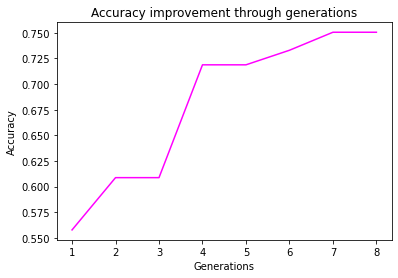

In [ ]:
generations=[1,2,3,4,5,6,7,8]
plt.plot(generations,performances,color='magenta')
plt.xlabel('Generations')
plt.xticks([1,2,3,4,5,6,7,8])
plt.ylabel('Accuracy')
plt.title('Accuracy improvement through generations')
plt.show()